# Stellar objects identification with Machine Learning

### Inteligencia Artificial para los Sistemas de Control Autónomos
### Máster de Ciencia y Tecnología desde el Espacio


## Objectives

- Deal with an open classification problem of tabular data.
- Deal with an unbalanced dataset.
- Hyperparameter optimization with grid and random search.

## Introduction

Blablabla.

Remember that the workflow usually implemented in ML projects is as follows.

    Data adquisition
    Exploratory analysis
    Data preprocessing
    Model training
    Model validation

https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17


*    obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
*    alpha = Right Ascension angle (at J2000 epoch)
*    delta = Declination angle (at J2000 epoch)
*    u = Ultraviolet filter in the photometric system
*    g = Green filter in the photometric system
*    r = Red filter in the photometric system
*    i = Near Infrared filter in the photometric system
*    z = Infrared filter in the photometric system
*    run_ID = Run Number used to identify the specific scan
*    rereun_ID = Rerun Number to specify how the image was processed
*    cam_col = Camera column to identify the scanline within the run
*    field_ID = Field number to identify each field
*    spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
*    class = object class (galaxy, star or quasar object)
*    redshift = redshift value based on the increase in wavelength
*    plate = plate ID, identifies each plate in SDSS
*    MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
*    fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

## Background

## Unbalanced classes
There are several actions that can be taken to address an unbalanced dataset, the best approach will depend on the problem and the data itself. 

The usual precision and recall metrics used in classification, when there is unbalanced classes, lose reliability. Imagine, for example, a dataset with 99% of instances of a class A, and only 1% of class B. If we apply a dummy classifier that classifies everything as A, we will obtain an accuracy of 99%, which suggests excellent performance, but clearly this classifier will not be working correctly. For this reason accuracy and recall are rarely used with unbalanced datasets.

One of the most commonly used metrics with unbalanced data is F1, which is defined as the harmonic mean of the precision and recall:

$F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$.

F1 is defined in a range from zero to one, with one corresponding to a perfect classification. The definition is made for binary classification problems, so it needs to be adapted to multi-label problems like the one we are dealing with. Scikit applies F1 to each class separately, obtaining several F1 values, which it then groups by means of an average. There are several methods to do this grouping, we will use the 'weighted' method, which weights the average by number of instances of each class, and is suitable for unbalanced datasets.

The most straightforward way to balance the classes is to undersample the majority class or oversample the minority class. A variation of the latter approach is to add noise to the oversampling in a controlled way, so as to bring more variety to the dataset, avoiding overlearning. In the context of Deep Learning this technique is known as "data augmentation".

<img align="center" src="smote.webp" width="300">

More advanced techniques involve synthetically generating new instances of the minority class. For example, [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) is a technique of some sophistication and quite popular that creates new instances of the minority class by sampling the straight line joining a minority class instance with some close neighbor. 

## Hyperparameter optimization

The performance of the models depends strongly on the hyperparameters, which is more clear when dealing with real-world problems. Since performance can be quantified, we can view this problem as a pure optimization problem, for which there are a multitude of techniques in the field of AI. 

<img align="center" src="random.png" width="300">
<img align="center" src="grid.png" width="300">

One of the most widely used hyperparameter optimization techniques in Machine Learning is provided by the Scikit-Learn function *GridSearchCV()*, which is provided with the hyperparameters to be optimized and a range of values to be searched. The function creates a combination of hyperparameters and trains the model with each combination, returning the combination that performs best. It can apply cross-validation if required to.

```Python
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()

parameters = {'kernel':('linear', 'rbf'), 
              'C':[1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)
clf.best_params_
```

Please observe that *GridSearchCV()* returns an object that contains the result of the search, but behaves like a model.

Since the search space increases exponentially with the number of hyperparameters to be optimized, grid search becomes computationally intractable with some ease. A randomized search may be useful in these cases (*see RandomizedSearchCV()*), or other much more advanced methods such as bayesian optimization of Genetic Algorithms.


## Imports

In [43]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Data adquisition

In [44]:
df = pd.read_csv("stellar.zip")
df = df.drop(['obj_ID','run_ID','rerun_ID','cam_col','field_ID','fiber_ID', 'spec_obj_ID'], axis = 1)

In [45]:
df.head()

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187


In [46]:
df.shape

(100000, 11)

In [47]:
df.isna().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
plate       0
MJD         0
dtype: int64

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,177.629117,96.502241,0.005528,127.518222,180.900700,233.895005,359.999810
delta,100000.0,24.135305,19.644665,-18.785328,5.146771,23.645922,39.901550,83.000519
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245
plate,100000.0,5137.009660,2952.303351,266.000000,2526.000000,4987.000000,7400.250000,12547.000000
MJD,100000.0,55588.647500,1808.484233,51608.000000,54234.000000,55868.500000,56777.000000,58932.000000


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'i'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'redshift'}>,
        <AxesSubplot:title={'center':'plate'}>],
       [<AxesSubplot:title={'center':'MJD'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

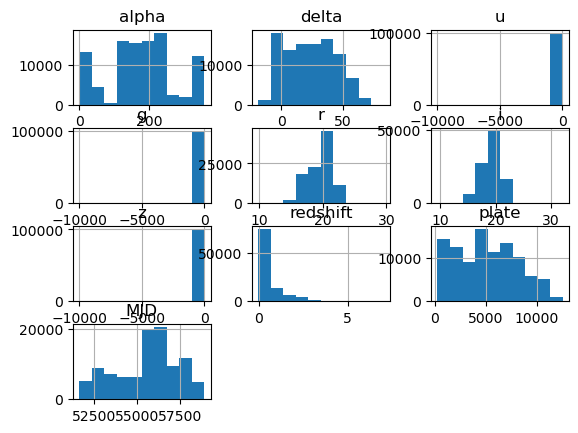

In [49]:
df.hist()

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'i'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'redshift'}>,
        <AxesSubplot:title={'center':'plate'}>],
       [<AxesSubplot:title={'center':'MJD'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

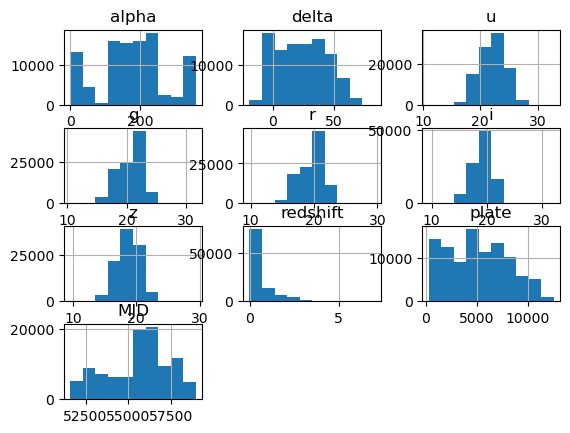

In [50]:
df = df[df['u'] > -9000]
df = df[df['redshift'] > -9000]
df.hist()

In [51]:
df.shape

(99999, 11)

In [52]:
df['class'].value_counts()

GALAXY    59445
STAR      21593
QSO       18961
Name: class, dtype: int64

In [1]:
#sns.pairplot(df, hue="class")

In [54]:
from sklearn.preprocessing import StandardScaler

x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [55]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [58]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
y_model = dummy_clf.predict(x_test)
score = dummy_clf.score(x_test, y_test)
dummy_score_ = np.mean(score)

print('Accuracy : %.3f' % (dummy_score_))

Accuracy : 0.594


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

      GALAXY       0.59      1.00      0.75     19590
         QSO       0.00      0.00      0.00      6306
        STAR       0.00      0.00      0.00      7104

    accuracy                           0.59     33000
   macro avg       0.20      0.33      0.25     33000
weighted avg       0.35      0.59      0.44     33000



/home/david/anaconda3/envs/ml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/anaconda3/envs/ml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/anaconda3/envs/ml37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
y_model = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.963


In [61]:
svm_clf = SVC(kernel='rbf', C=1, random_state=0)
svm_clf.fit(x_train, y_train)
y_model = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.963


In [63]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_model = clf.predict(x_test)
score = clf.score(x_test, y_test)
clf_score_ = np.mean(score)

print('Accuracy : %.3f' % (clf_score_))

Accuracy : 0.978
